# Basic Prototype 2

Builds on Basic Prototype 1, adds yolov8 pose detection. Landmarks will be saved in a datastructure which then will be visualised and probably exported as a JSON so that it can be trained on Google Colab. This prototype focuses on testing if an AI model can be trained to interpolate and output the correct landmarks to continue the video sequence after being trained on the sequences of the videos.

Pose detection wise, Openpose is better since it has more landmarks and also tracks the foot, it is also based on C++ so it's quicker, but I cannot get openpose to work yet, so I will implement using YOLOv8 for now just to test the AI model structure. 

Mediapipe is also a possibility but it can only detect 1 person at a time and is much slower. 

Still the broadcast on OBS has to be started manually first.

In [2]:
# imports

import pytchat
import cv2
import glob
import ultralytics
import torch
import time
import numpy as np
from collections import defaultdict
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import mdn
import random
import tensorflow as tf

files = glob.glob('G:/UAL_Thesis/raw_videos/*')
print(files)


['G:/UAL_Thesis/raw_videos\\idle_bob_1.MOV', 'G:/UAL_Thesis/raw_videos\\idle_bob_2.MOV', 'G:/UAL_Thesis/raw_videos\\jump_out_in.MOV', 'G:/UAL_Thesis/raw_videos\\step_f_b.MOV', 'G:/UAL_Thesis/raw_videos\\step_l.MOV', 'G:/UAL_Thesis/raw_videos\\step_l_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r_l.MOV']


In [3]:
from PIL import Image

def draw_skeleton(result):
    """draw frame from YOLOv8 results"""
    for r in result:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    return np.array(im)[..., ::-1]  # Convert PIL Image back to BGR numpy array

In [4]:
# test YOLOv8 pose recognition with 1 file first

"""Check hardware and load model"""


# Check if GPU is available otherwise use CPU for torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# load model
model = ultralytics.YOLO('yolov8n-pose.pt')




def predict_pose(video_path, model = model):
    # predict

    cap = cv2.VideoCapture(video_path)
    start_time = time.time()

    # resize cv2 window

    # Get the original video dimensions
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the desired width and calculate the height to maintain the aspect ratio
    desired_width = 540  # You can change this value
    aspect_ratio = height / width
    desired_height = int(desired_width * aspect_ratio)

    # Get video, pose analyse and display pose detection frame by frame
    pose_results = defaultdict(int)
    i=0

    while(cap.isOpened() and time.time()):
        ret, frame = cap.read()
        if ret == True:
            result = model.predict(frame)
            pose_results[i] = result
            i = i+1
            annotated_frame = draw_skeleton(result)
            # Resize the frame while maintaining the aspect ratio
            resized_frame = cv2.resize(annotated_frame, (desired_width, desired_height))
            cv2.imshow('Frame', resized_frame)

            # Press Q on keyboard to exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows

    return pose_results



In [5]:
# Check if keypoints.csv exists
import os
if not os.path.exists("keypoints.csv"):

    all_pose_results = defaultdict(int)

    for file in files:
        pose_results = predict_pose(file)
        all_pose_results[file.split('\\')[-1]] = pose_results

In [6]:
def define_keypoints():
    return {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}

In [7]:
from collections import defaultdict

# LSTM - adapted from AI for media 
# https://git.arts.ac.uk/tbroad/AI-4-Media-22-23/blob/main/Week%205.1%20LSTM%20for%20forecasting%20and%20movement%20generation/Generating_Movement_Sequences_with_LSTM.ipynb

# define keypoints
keypoints = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}


if not os.path.exists("keypoints.csv"):
    # convert tensor of xy coordinate per frame into a pandas time series
    keypoints_dict_master = defaultdict(dict)

    for file, video in all_pose_results.items():
        keypoints_dict_master[file] = defaultdict(dict)
        for frame, results in pose_results.items():
            if frame not in keypoints_dict_master[file]:
                keypoints_dict_master[file][frame] = {}
            for idx, person in enumerate(results):
                # Check if person has the attribute 'keypoints' and it has the attribute 'xy'
                if hasattr(person, 'keypoints') and hasattr(person.keypoints, 'xy'):
                    tensor_values = person.keypoints.xy

                    # Convert tensor to dictionary format
                    keypoint_coordinates = {key: tensor_values[0][value] for key, value in keypoints.items() if value < len(tensor_values[0])}

                    # Use idx as a unique identifier for each person
                    keypoints_dict_master[file][frame][idx] = keypoint_coordinates


# LSTM

In [8]:
if not os.path.exists("keypoints.csv"):
    # convert to pandas of each keypoint coordinate for each frame

    # Flatten the dictionary
    rows = []

    for file, video in keypoints_dict_master.items():
        for frame, persons in video.items():
            for person, keypoints in persons.items():
                row = {'file':file,'frame': frame, 'person': person}
                for keypoint, coordinates in keypoints.items():
                    row[f'{keypoint}_x'] = coordinates[0]
                    row[f'{keypoint}_y'] = coordinates[1]
                rows.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(rows)
    df.to_csv('keypoints.csv')

else:
    import pandas as pd
import re

# Function to convert tensor string to float
def tensor_string_to_float(tensor_str):
    """Converts a tensor string representation to a float."""
    # Extract the numerical value from the string using regex
    match = re.search(r'tensor\(([\d.-]+)\)', tensor_str)
    return float(match.group(1)) if match else None

# Load the CSV file
df = pd.read_csv('keypoints.csv')

# Convert tensor string columns to floats
tensor_columns = df.columns[4:]  # Selecting columns from nose_x onwards
for col in tensor_columns:
    df[col] = df[col].apply(tensor_string_to_float)

df.drop(columns=['Unnamed: 0'], inplace=True)

# Optional: Convert to actual tensor objects using PyTorch (if needed)
# import torch
# for col in tensor_columns:
#     df[col] = df[col].apply(lambda x: torch.tensor(x))

# Now, df contains the processed data


In [9]:


df.head()

,file,frame,person,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,idle_bob_1.MOV,0,0,315.4402,326.7383,349.0056,297.8242,282.8443,300.4351,404.4678,...,247.7921,956.8067,395.4081,1306.9662,264.2390,1296.5691,374.6571,1595.1146,282.4957,1583.3298
1,idle_bob_1.MOV,1,0,314.8095,327.1753,348.5630,298.2261,282.1539,300.7230,404.2600,...,247.8507,956.1669,395.2300,1307.1984,263.9956,1296.5778,374.4688,1595.9645,282.1102,1583.9807
2,idle_bob_1.MOV,2,0,315.7643,328.1407,349.8134,299.1344,282.9068,301.5251,405.8614,...,247.8356,956.4417,396.0627,1306.8156,264.2411,1295.8882,374.3769,1594.2859,282.0742,1582.1005
3,idle_bob_1.MOV,3,0,315.7721,330.7705,350.0541,302.0490,283.3035,304.1046,406.1350,...,247.7006,956.8440,396.5027,1307.0717,264.6685,1296.7766,375.0370,1594.3048,282.7548,1583.6675
4,idle_bob_1.MOV,4,0,317.3219,331.2078,351.1437,302.4129,284.7657,304.6754,406.3033,...,248.4987,958.8131,396.5564,1308.1497,265.1670,1297.6298,374.6241,1594.6077,282.8113,1582.9050


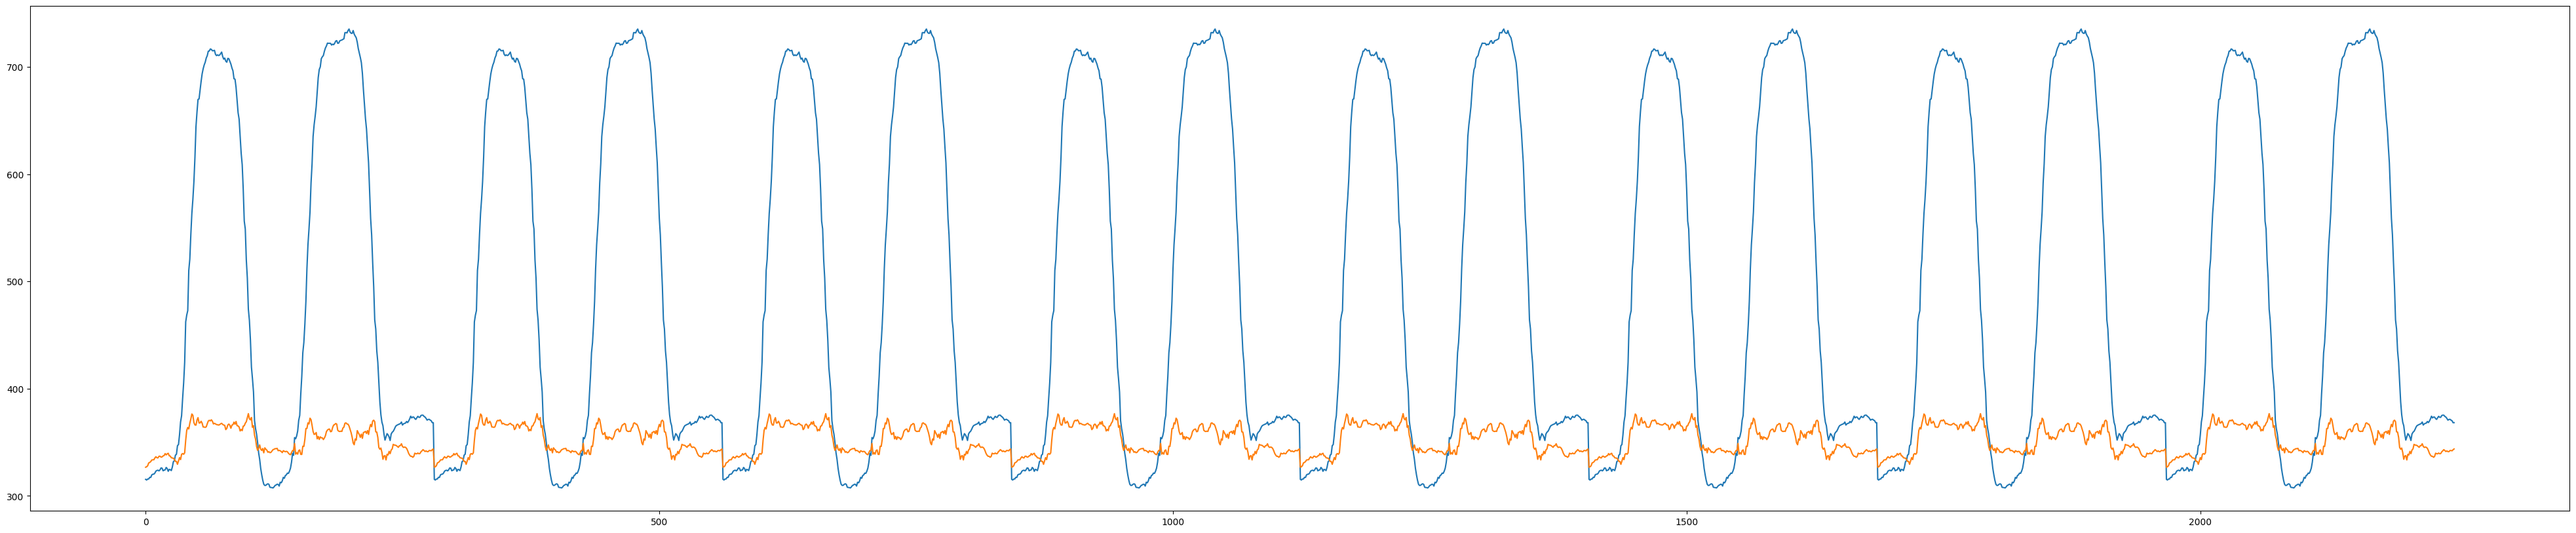

In [10]:
import matplotlib.pyplot as plt

# sample visualise change in nose_x, nose_y position

# Plotting the change of coordinates values for 1 body joint, e.g. the nose
plt.figure(figsize=(50, 10))

plt.plot(df['nose_x']) #blue line
plt.plot(df['nose_y']) #orange line

plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
        
        # output is list of list of num_steps number of rows (e.g. num_setps =  50 will be 50 first rows, all columns)
    return xs

def seq_to_singleton_format(examples):
    # Takes the sliced sequences and separates each sequence into input (all elements except the last one) and output (just the last element).
    # up until last sequence used as primer
    
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)  

video_file_names = set(df['file'])

X = []
y = []

for video_file_name in tqdm(video_file_names):
    sliced_df = df[df['file'] == video_file_name]

    # Turning our dataframe structure into an array, excluding the first 3 columns of video name, person and frame
    seq = np.array(sliced_df.iloc[:len(sliced_df),3:])

    # Normalising our data with min max
    sc = MinMaxScaler()
    seq = sc.fit_transform(seq)

    # Defining and using our window size to create our inputs X and outputs y
    SEQ_LEN = 50
    slices = slice_sequence_examples(seq, SEQ_LEN+1)
    sliced_X, sliced_y = seq_to_singleton_format(slices)

    X.extend(sliced_X)
    y.extend(sliced_y)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

100%|██████████| 8/8 [00:00<00:00, 727.29it/s]

Number of training examples:
X: (1832, 50, 34)
y: (1832, 34)


In [12]:
# Number of training examples:
# X: (8, 2196, 50, 34)
# y: (8, 2196, 34)

In [13]:
# train test split

from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1227, 50, 34), (1227, 34), (605, 50, 34), (605, 34))

In [43]:
# Training Hyperparameters:
BATCH_SIZE = 64
HIDDEN_UNITS = 512 #256
EPOCHS =  1000
OUTPUT_DIMENSION = 34 # the number of coordinates x2 for x and y
NUMBER_MIXTURES = 10

# Sequential model
model = Sequential()


# # If GPU is available set model to use half-precision floating-point numbers
# if torch.cuda.is_available():
#     model.half().to(device)

# Add two LSTM layers, make sure the input shape of the first one is (?, fit into any sequence length?, 26)
model.add(LSTM(HIDDEN_UNITS, batch_input_shape=(None,None,OUTPUT_DIMENSION), return_sequences=True))
model.add(LSTM(HIDDEN_UNITS))



# Here's the MDN layer, need to specify the output dimension (26) and number of mixtures (10)
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))

# If you did not want to use an MDN, you could instead add a Dense Layer
# model.add(Dense(26))

# Now we compile the MDN RNN - need to use a special loss function with the right number of dimensions and mixtures.
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer='adam')

# This compiler would be used if we only used a Dense layer instead of the MDN
# model.compile(optimizer='adam', loss='mean_squared_error')

# Let's see what we have:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, None, 512)         1120256   
                                                                 
 lstm_16 (LSTM)              (None, 512)               2099200   
                                                                 
 mdn_3 (MDN)                 (None, 690)               353970    
                                                                 
Total params: 3,573,426
Trainable params: 3,573,426
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)
model.save_weights('LSTM_weights.h5')


Epoch 1/500
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
29/29 [==============================] - 5s 18ms/step - loss: -6.7504
Epoch 2/500
29/29 [==============================] - 0s 17ms/step - loss: -30.1666
Epoch 3/500
29/29 [==============================] - 0s 17ms/step - loss: -38.3674
Epoch 4/500
29/29 [==============================] - 0s 17ms/step - loss: -43.1428
Epoch 5/500
29/29 [==============================] - 0s 17ms/step - loss: -40.9285
Epoch 6/500
29/29 [==============================] - 0s 17ms/step - loss: -50.8787
Epoch 7/500
29/29 [==============================] - 0s 17ms/step - loss: -54.1818
Epoch 8/500
29/29 [==============================] - 0s 17ms/step - loss: -56.3640
Epoch 9/500
29/29 [==============================] - 0s 17ms/step - loss: -60.2190
Epoch 10/500
29/29 [==============================] - 0s 17ms/step - loss: -61.6468
Epoch 11/500
29/29 [==========================

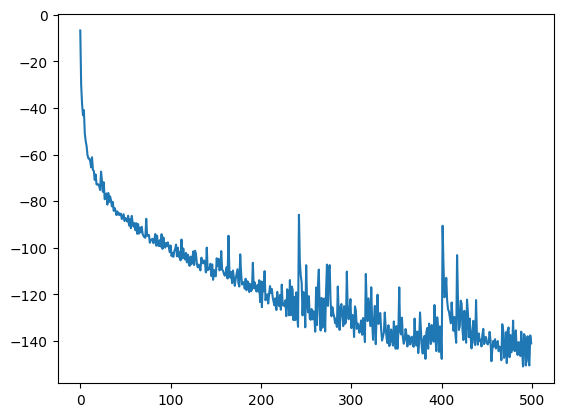

In [16]:
# Plot our loss
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [17]:
# Version 1
# Priming as if saying "get inspiration from" these many inputs, it gives it from context 
# Imagine that it has been trained on approx 1h of dancing
# This is tell it to use inspiration from a specific part
def prime_model(input):
    pred = model.predict(tf.expand_dims(input, axis=0))
    
# Predicting for a sequence of frames, p is the starting point, length the number of frames
def predict_sequence(p, length, temp=2.5, sigma_temp=0.1):
    result = [p.reshape(1,OUTPUT_DIMENSION)]
    for i in range(length):
        pred = model.predict(p.reshape(1,1,OUTPUT_DIMENSION))
        p = mdn.sample_from_output(pred[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temp, sigma_temp=sigma_temp)
        result.append(p)
    return tf.concat(result, axis=0)

model.reset_states()
# how many should be primed?
n=3
prime_model(X_test[0][:n]) # prime model with the first n points - change this depending on video
pred = predict_sequence(X_test[0][n], 500) #start from point n and predict for 50 more
pred.shape

1/1 [==============================] - 0s 14ms/step


TensorShape([501, 34])

In [18]:
# Reversing the normalisation we did before the training
pred_f = sc.inverse_transform(pred)

# Storing predictions in a dataframe
df_f = pd.DataFrame(pred_f)

pred_f.shape

(501, 34)

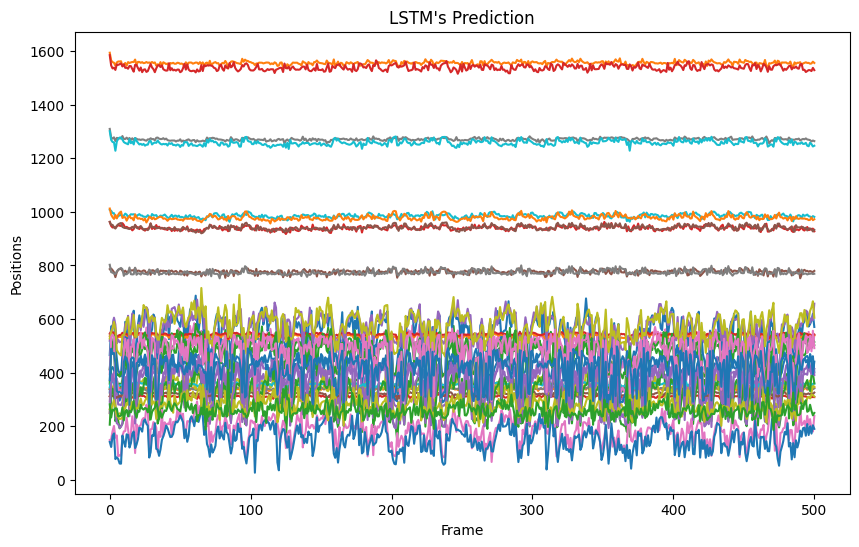

In [19]:
# Plotting the predicted/generated coordinates
plt.figure(figsize=(10, 6))
plt.plot(pred_f, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Frame')
plt.ylabel('Positions')
plt.show()

In [20]:
pd.DataFrame(pred_f).head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,325.526100,339.189100,358.729600,310.421300,291.943800,312.474200,409.783000,338.148100,248.633500,344.990500,...,249.527500,962.497600,394.022400,1309.451000,263.901600,1300.917500,371.576000,1593.786000,281.538500,1584.655500
1,412.428419,347.147030,481.847260,317.842794,371.427109,330.372578,507.902437,347.715225,332.654380,368.866493,...,361.573548,951.255943,533.140320,1277.277763,261.468243,1268.399227,489.088598,1564.859354,232.435497,1546.238157
2,420.802119,341.551346,470.899521,312.722414,393.415675,326.085047,514.119738,343.418694,341.500238,365.408671,...,372.870871,951.263521,541.931542,1273.266888,279.713950,1260.502462,469.968562,1558.608209,262.229733,1535.094603
3,408.318482,338.192130,481.568385,310.312390,388.346188,323.320311,502.733151,343.419091,357.485213,358.918903,...,401.206205,941.733115,532.545321,1277.940392,297.695898,1259.389006,473.066736,1556.408343,258.383792,1538.018956
4,387.806955,334.263115,383.923172,311.289277,333.669203,308.832023,425.920009,341.805030,282.763958,348.009296,...,261.598146,937.576310,383.706385,1264.121634,268.691287,1228.059141,435.694525,1545.246755,266.745851,1529.666928


In [21]:
pred_df  = pd.DataFrame(pred_f)
pred_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,...,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,400.089431,339.739532,448.016350,310.671901,367.488708,318.882659,482.759394,340.305993,322.647726,355.070400,...,335.974247,941.223291,461.293773,1271.044642,275.842109,1258.160977,411.635608,1555.692421,258.375796,1538.288342
std,52.223174,4.352185,56.192352,4.362684,52.286445,5.862820,49.780536,5.641466,43.208769,6.916884,...,75.434630,8.120115,78.168294,4.881919,29.038390,9.626405,58.923172,6.414235,25.173087,10.188236
min,262.852451,322.861514,303.483248,292.048294,201.968663,300.697652,362.282228,323.390230,223.486199,322.535264,...,191.829171,919.850994,285.801302,1255.275910,199.379804,1228.059141,266.730759,1534.818438,186.122884,1515.236350
25%,372.512581,336.844764,396.151558,308.268832,328.025090,314.144338,447.996518,336.873772,288.606632,350.598770,...,269.577854,935.844243,412.157613,1267.749118,257.372640,1251.488648,386.142593,1552.557111,241.256672,1530.215839
50%,413.679700,339.902548,467.631849,311.047613,380.264611,320.222320,493.329571,341.275522,332.121457,356.390524,...,353.180851,940.509471,496.117480,1271.165967,274.962785,1256.976246,431.545475,1556.115187,256.710449,1536.935932
75%,439.405746,342.560939,489.420395,313.382430,407.226089,323.692821,519.808032,344.512984,355.320020,360.043532,...,398.292352,945.823935,519.687399,1274.419471,293.125262,1263.959078,453.002952,1558.959976,271.888040,1547.048556
max,503.578605,349.599810,588.173104,321.235468,468.853483,330.577144,584.361589,353.307014,435.524348,368.866493,...,485.877687,962.497600,570.317241,1309.451000,360.454649,1300.917500,497.679581,1593.786000,410.172072,1584.655500


In [37]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# prediction results dataframe
pred_df = pd.DataFrame(pred_f)
scaled_df = pred_df/2 # Scale data


model.reset_states()
prime_model(primer) # prime model with the first n points - change this depending on video
pred = predict_sequence(primer[-1], 500) #start from primer's last frame and predict for 50 more

# Reversing the normalisation we did before the training
pred_f = sc.inverse_transform(pred)

# Storing predictions in a dataframe
pred_df = pd.DataFrame(pred_f)

scaled_df = pred_df/2 # Scale data


# Define the pairs of keypoints for the skeleton

orange = (0, 165, 255)
blue = (255, 0, 0)
green = (0, 255, 0)


skeleton_pairs = [
    ("nose", "left_eye", orange),
    ("nose", "right_eye", orange),
    ("left_eye", "left_ear",orange),
    ("left_ear", "left_shoulder",orange),
    ("right_eye", "right_ear",orange),
    ("right_ear", "right_shoulder",orange),
    ("left_shoulder", "right_shoulder",orange),
    ("left_shoulder", "left_elbow",green),
    ("right_shoulder", "right_elbow",blue),
    ("right_shoulder", "right_hip",orange),
    ("left_elbow", "left_wrist",green),
    ("left_shoulder", "left_hip",orange),
    ("right_elbow", "right_wrist",blue),
    ("left_hip", "right_hip",orange),
    ("left_hip", "left_knee",green),
    ("right_hip", "right_knee",blue),
    ("left_knee", "left_ankle",green),
    ("right_knee", "right_ankle",blue),
    
]

keypoints = define_keypoints()


try:
    
    window_y,window_x = 500,1500

    # Set up the VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or use 'MP4V' for .mp4 videos
    out = cv2.VideoWriter(f"video_documentation/all_{EPOCHS}_epochs_256_hidden_proto2_ai4medialstm.mp4", fourcc, 20.0, (window_y, window_x))
    # Iterate over each row in the dataframe
    for _, row in scaled_df.iterrows():
        image = np.zeros((window_x, window_y, 3), dtype=np.uint8)
        
        # Draw the keypoints and labels
        for key, idx in keypoints.items():
            x = int(row[idx * 2])
            y = int(row[idx * 2 + 1])
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            cv2.putText(image, key, (x + 5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Draw the skeleton
        for pair in skeleton_pairs:
            pt1_idx = keypoints[pair[0]] * 2
            pt2_idx = keypoints[pair[1]] * 2
            colour = pair[2]
            pt1 = (int(row[pt1_idx]), int(row[pt1_idx + 1]))
            pt2 = (int(row[pt2_idx]), int(row[pt2_idx + 1]))
            cv2.line(image, pt1, pt2, colour, 2)

        cv2.imshow("Keypoints", image)
        out.write(image)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break


finally:
    out.release()
    # cv2.destroyAllWindows()


1/1 [==============================] - 0s 14ms/step


In [23]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,325.526100,339.189100,358.729600,310.421300,291.943800,312.474200,409.783000,338.148100,248.633500,344.990500,...,249.527500,962.497600,394.022400,1309.451000,263.901600,1300.917500,371.576000,1593.786000,281.538500,1584.655500
1,412.428419,347.147030,481.847260,317.842794,371.427109,330.372578,507.902437,347.715225,332.654380,368.866493,...,361.573548,951.255943,533.140320,1277.277763,261.468243,1268.399227,489.088598,1564.859354,232.435497,1546.238157
2,420.802119,341.551346,470.899521,312.722414,393.415675,326.085047,514.119738,343.418694,341.500238,365.408671,...,372.870871,951.263521,541.931542,1273.266888,279.713950,1260.502462,469.968562,1558.608209,262.229733,1535.094603
3,408.318482,338.192130,481.568385,310.312390,388.346188,323.320311,502.733151,343.419091,357.485213,358.918903,...,401.206205,941.733115,532.545321,1277.940392,297.695898,1259.389006,473.066736,1556.408343,258.383792,1538.018956
4,387.806955,334.263115,383.923172,311.289277,333.669203,308.832023,425.920009,341.805030,282.763958,348.009296,...,261.598146,937.576310,383.706385,1264.121634,268.691287,1228.059141,435.694525,1545.246755,266.745851,1529.666928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,450.356323,342.634450,486.515479,307.793536,428.219025,322.403126,551.928549,343.600235,360.201111,360.194402,...,414.685033,938.313364,483.171157,1269.059735,309.871865,1244.723085,418.297684,1555.877689,257.059832,1528.954772
497,440.947283,343.432083,506.363509,306.196381,404.917444,318.280036,490.306877,340.981312,370.597791,354.275934,...,406.847510,937.821219,537.131835,1267.563875,303.502097,1257.880611,469.222501,1552.703526,279.964552,1528.625030
498,453.301752,333.017880,491.679170,308.615701,434.244672,324.275790,511.222895,337.623378,326.726723,354.519398,...,394.049155,935.204578,479.435786,1262.515777,318.544221,1252.845146,451.283839,1553.672765,257.142930,1525.300743
499,461.152226,342.505080,501.588838,308.765921,406.157540,319.169353,499.049849,337.654222,352.391676,358.609457,...,431.444751,926.779617,556.288861,1266.087167,316.400637,1243.855031,394.138812,1560.352837,240.472991,1537.266713


# With live chat loop

In [24]:
# Version 1
# Priming as if saying "get inspiration from" these many inputs, it gives it from context 
# Imagine that it has been trained on approx 1h of dancing
# This is tell it to use inspiration from a specific part
def prime_model(input):
    pred = model.predict(tf.expand_dims(input, axis=0))
    
# Predicting for a sequence of frames, p is the starting point, length the number of frames
def predict_sequence(p, length, temp=2.5, sigma_temp=0.1):
    result = [p.reshape(1,OUTPUT_DIMENSION)]
    for i in range(length):
        pred = model.predict(p.reshape(1,1,OUTPUT_DIMENSION))
        p = mdn.sample_from_output(pred[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temp, sigma_temp=sigma_temp)
        result.append(p)
    return tf.concat(result, axis=0)

model.reset_states()
# how many should be primed?
n=3
prime_model(X_test[0][:n]) # prime model with the first n points - change this depending on video
pred = predict_sequence(X_test[0][n], 500) #start from point n and predict for 50 more
pred.shape

1/1 [==============================] - 0s 16ms/step


TensorShape([501, 34])

In [34]:
def predict_and_play(primer):
    model.reset_states()
    prime_model(primer) # prime model with the first n points - change this depending on video
    pred = predict_sequence(primer[-1], 50) #start from primer's last frame and predict for 50 more
 
    # Reversing the normalisation we did before the training
    pred_f = sc.inverse_transform(pred)

    # Storing predictions in a dataframe
    pred_df = pd.DataFrame(pred_f)
    
    scaled_df = pred_df/2 # Scale data

    
    # Define the pairs of keypoints for the skeleton
    
    orange = (0, 165, 255)
    blue = (255, 0, 0)
    green = (0, 255, 0)
    
    
    skeleton_pairs = [
        ("nose", "left_eye", orange),
        ("nose", "right_eye", orange),
        ("left_eye", "left_ear",orange),
        ("left_ear", "left_shoulder",orange),
        ("right_eye", "right_ear",orange),
        ("right_ear", "right_shoulder",orange),
        ("left_shoulder", "right_shoulder",orange),
        ("left_shoulder", "left_elbow",green),
        ("right_shoulder", "right_elbow",blue),
        ("right_shoulder", "right_hip",orange),
        ("left_elbow", "left_wrist",green),
        ("left_shoulder", "left_hip",orange),
        ("right_elbow", "right_wrist",blue),
        ("left_hip", "right_hip",orange),
        ("left_hip", "left_knee",green),
        ("right_hip", "right_knee",blue),
        ("left_knee", "left_ankle",green),
        ("right_knee", "right_ankle",blue),
        
    ]

    keypoints = define_keypoints()


    try:
        
        window_y,window_x = 500,1500

        # Set up the VideoWriter
        # fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or use 'MP4V' for .mp4 videos
        # out = cv2.VideoWriter(f"video_documentation/all_{EPOCHS}_epochs_256_hidden_proto2_ai4medialstm.mp4", fourcc, 20.0, (window_y, window_x))
        # Iterate over each row in the dataframe
        for _, row in scaled_df.iterrows():
            image = np.zeros((window_x, window_y, 3), dtype=np.uint8)
            
            # Draw the keypoints and labels
            for key, idx in keypoints.items():
                x = int(row[idx * 2])
                y = int(row[idx * 2 + 1])
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                cv2.putText(image, key, (x + 5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            
            # Draw the skeleton
            for pair in skeleton_pairs:
                pt1_idx = keypoints[pair[0]] * 2
                pt2_idx = keypoints[pair[1]] * 2
                colour = pair[2]
                pt1 = (int(row[pt1_idx]), int(row[pt1_idx + 1]))
                pt2 = (int(row[pt2_idx]), int(row[pt2_idx + 1]))
                cv2.line(image, pt1, pt2, colour, 2)
    
            cv2.imshow("Keypoints", image)
            out.write(image)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break


    finally:
        out.release()
        # cv2.destroyAllWindows()


In [28]:
# Create an empty frame (black image) of size 500x1500 for OBS capture
image = np.zeros((500, 1500, 3), dtype=np.uint8)
# Display the image
cv2.imshow("Keypoints", image)

In [33]:
# choose videos using live chat 

import glob

# testing playing video with choice - choices are numbers 1-5

def make_videos_dict():
    # files = glob.glob('/Volumes/My Passport/UAL_Thesis/raw_videos/*')
    files = glob.glob('G:/UAL_Thesis/raw_videos/*')
    files = [f.split('/')[-1].split('\\')[-1] for f in files]
    files_dict = {str(i+1): value for i, value in enumerate(files)}
# 
    return files_dict
  
def test_choose_videos(i , videos_dict):
    return videos_dict[i]

import cv2
import time

# play video according to live chat command using cv2 
# raw_videos_path = '/Volumes/My Passport/UAL_Thesis/raw_videos'
raw_videos_path = 'G:/UAL_Thesis/raw_videos/*'
videos_dict = make_videos_dict()

    
from random import randrange

def get_primer(choice, df, n=3):
    # choice has to be name of video + .MOV
    sliced_df = df[df['file'] == choice]
    # Turning our dataframe structure into an array, excluding the first 3 columns of video name, person and frame
    seq = np.array(sliced_df.iloc[:len(sliced_df),3:])
    # Normalising our data with min max
    sc = MinMaxScaler()
    array_video = sc.fit_transform(seq)
    rand = randrange(len(array_video)-(n+1))
    primer = np.array(array_video[rand:rand+n ])
    return primer
    


# play video according to live chat command using cv2

import pytchat
# video_id:https://youtu.be/sg2C2Zz4xBE
# Create an empty frame (black image) of size 500x1500 for OBS capture
image = np.zeros((500, 1500, 3), dtype=np.uint8)

# Display the image
cv2.imshow("Keypoints", image)

# live stream must start first, then copy the id from the live stream URL
chat = pytchat.create(video_id="sg2C2Zz4xBE")
while chat.is_alive():
    for c in chat.get().sync_items():
        print(f"{c.datetime} [{c.author.name}]- {c.message}")
        choice = test_choose_videos(c.message, videos_dict)
        print(choice)
        n=3
        primer = get_primer(choice, df, n=n)
        predict_and_play(primer)
        

2023-09-06 14:38:29 [Moon Rabbit]- 1
idle_bob_1.MOV
1/1 [==============================] - 0s 14ms/step
2023-09-06 14:38:54 [Moon Rabbit]- 2
idle_bob_2.MOV
1/1 [==============================] - 0s 14ms/step
2023-09-06 14:38:55 [Moon Rabbit]- 3
jump_out_in.MOV
1/1 [==============================] - 0s 14ms/step
2023-09-06 14:39:11 [Moon Rabbit]- 1
idle_bob_1.MOV
1/1 [==============================] - 0s 14ms/step
2023-09-06 14:39:13 [Moon Rabbit]- 4
step_f_b.MOV
1/1 [==============================] - 0s 15ms/step
2023-09-06 14:39:14 [Moon Rabbit]- 5
step_l.MOV
1/1 [==============================] - 0s 15ms/step
2023-09-06 14:39:26 [Moon Rabbit]- 2
idle_bob_2.MOV
1/1 [==============================] - 0s 16ms/step
2023-09-06 14:39:40 [Moon Rabbit]- 3
jump_out_in.MOV
1/1 [==============================] - 0s 16ms/step


In [ ]:
c.message

'1'

In [ ]:
X_test[c.message][:n]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
primer

array([[    0.97436,      0.6664,     0.98188,     0.74204,     0.98166,     0.67558,     0.98133,     0.69151,     0.98572,     0.51172,       0.991,     0.56789,     0.98626,     0.50339,      0.9789,     0.42607,     0.99707,     0.49004,     0.89699,     0.41396,     0.94356,     0.11971,     0.97684,
            0.28139,     0.99042,     0.24089,     0.98502,     0.21855,     0.96651,     0.27052,     0.98953,     0.10026,     0.99753,     0.13675],
       [    0.97531,      0.6732,     0.98231,     0.74866,      0.9827,     0.68441,     0.98167,     0.69988,     0.98758,     0.52342,     0.99208,     0.60035,     0.98834,      0.5141,     0.98415,     0.48569,     0.99489,     0.50949,     0.90984,     0.46229,     0.94216,     0.16177,     0.97799,
            0.28126,     0.99258,     0.23677,      0.9861,     0.23467,     0.96866,     0.28422,     0.99184,     0.10529,     0.99583,     0.14676],
       [    0.97606,     0.66805,     0.98337,      0.7436,     0.98363,     0.678

In [ ]:
X_test[0][:n]

array([[    0.03881,     0.21778,     0.03617,     0.22747,    0.037147,      0.2107,    0.038402,     0.24325,    0.037945,     0.17696,     0.06887,     0.37832,    0.036167,     0.47312,    0.074463,     0.47462,    0.092014,     0.79413,    0.054177,     0.89089,     0.18925,     0.67499,    0.087776,
             0.6413,    0.062596,     0.62403,     0.10688,     0.95368,    0.070454,     0.83136,      0.1368,     0.89319,     0.11656,     0.75204],
       [   0.039378,     0.25413,    0.036884,     0.26424,    0.037928,     0.24378,    0.038261,     0.27282,    0.037899,     0.19769,    0.067779,     0.39173,    0.034317,       0.497,    0.074851,     0.45731,    0.090189,     0.79954,    0.053466,     0.88678,     0.18947,     0.67951,     0.08782,
            0.64526,     0.06231,     0.63244,     0.10868,     0.95773,    0.071563,     0.84624,     0.13773,     0.89473,     0.11875,     0.77044],
       [   0.044629,     0.23031,    0.041466,     0.24289,    0.042273,     0.221

In [ ]:
type(X_test[0][:n])

numpy.ndarray

In [ ]:
# https://docs.ultralytics.com/modes/predict/#keypoints

for person in result:
   print(person.keypoints.xy)

In [ ]:
# df primers
df.head()

,file,frame,person,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,idle_bob_1.MOV,0,0,315.4402,326.7383,349.0056,297.8242,282.8443,300.4351,404.4678,...,247.7921,956.8067,395.4081,1306.9662,264.2390,1296.5691,374.6571,1595.1146,282.4957,1583.3298
1,idle_bob_1.MOV,1,0,314.8095,327.1753,348.5630,298.2261,282.1539,300.7230,404.2600,...,247.8507,956.1669,395.2300,1307.1984,263.9956,1296.5778,374.4688,1595.9645,282.1102,1583.9807
2,idle_bob_1.MOV,2,0,315.7643,328.1407,349.8134,299.1344,282.9068,301.5251,405.8614,...,247.8356,956.4417,396.0627,1306.8156,264.2411,1295.8882,374.3769,1594.2859,282.0742,1582.1005
3,idle_bob_1.MOV,3,0,315.7721,330.7705,350.0541,302.0490,283.3035,304.1046,406.1350,...,247.7006,956.8440,396.5027,1307.0717,264.6685,1296.7766,375.0370,1594.3048,282.7548,1583.6675
4,idle_bob_1.MOV,4,0,317.3219,331.2078,351.1437,302.4129,284.7657,304.6754,406.3033,...,248.4987,958.8131,396.5564,1308.1497,265.1670,1297.6298,374.6241,1594.6077,282.8113,1582.9050


In [ ]:
# GAN



array([[     315.44,      326.74,      349.01,      297.82,      282.84,      300.44,      404.47,      326.98,      244.32,      335.13,      465.26,      528.93,      205.05,       537.5,      521.11,      782.97,      148.11,      798.25,      527.56,      1002.4,       140.9,      1006.9,      412.07,
             957.28,      247.79,      956.81,      395.41,        1307,      264.24,      1296.6,      374.66,      1595.1,       282.5,      1583.3],
       [     314.81,      327.18,      348.56,      298.23,      282.15,      300.72,      404.26,      327.32,      243.47,      335.18,      464.75,      528.77,      204.72,      537.14,      520.85,      782.11,      148.57,      797.53,      527.88,      1001.9,      141.18,      1007.4,      412.11,
             956.76,      247.85,      956.17,      395.23,      1307.2,         264,      1296.6,      374.47,        1596,      282.11,        1584],
       [     315.76,      328.14,      349.81,      299.13,      282.91,      301.